In [1]:
%%html
<style>
.output_subarea.output_text.output_stream.output_stdout > pre {
    width:max-content;
}
.p-Widget.jp-RenderedText.jp-OutputArea-output > pre {
   width:max-content;
}
</style>

In [ ]:
#import dask.array as da
#import dask.dataframe as dd

In [2]:
import pandas as pd
import numpy as np
import scipy.optimize as sco
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline

from pyspark.sql import SparkSession, Window, Row
from pyspark.sql.types import StringType, DateType
from pyspark.sql.functions import lit, year, month, dayofmonth, last_day, col, array, explode, struct, udf, to_date, month, year, percent_rank, when, lag, first, avg
from pyspark.sql.functions import sum as spark_sum, max as spark_max, min as spark_min

In [3]:
import OpSpark

In [4]:
spark = SparkSession.builder.appName('Rank_Median').getOrCreate()
sc = spark.sparkContext
sc

<SparkContext master=local[*] appName=Rank_Median>

In [5]:
#dd.read_parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")

In [6]:
## por temas de replicación, siempre es mejor convertir el archivo a leer en formato csv

monthly_data_df = spark.read.parquet("data/master/ophelia/data/OpheliaData/analytical_base_table")
index_vector_csv = spark.read.csv("data/raw/csv/unique_dateprice_vector.csv", header=True, inferSchema=True)

In [7]:
from datetime import datetime

def datetime_object(datetime_str):
    print(datetime_str)
    datetime_object = datetime.strptime(datetime_str, '%d/%m/%y').date()
    return datetime_object

datetime_object_udf = udf(f=datetime_object, returnType=DateType())

In [8]:
index_vector_schema = index_vector_csv.select("MXWDU_Index", datetime_object_udf(col("operation_date")).alias('operation_date'))
index_vector_schema.show(10, False)

+-----------+--------------+
|MXWDU_Index|operation_date|
+-----------+--------------+
|51.12      |2016-01-01    |
|54.830002  |2016-01-04    |
|54.880001  |2016-01-05    |
|54.049999  |2016-01-06    |
|52.790001  |2016-01-07    |
|52.18      |2016-01-08    |
|52.240002  |2016-01-11    |
|52.580002  |2016-01-12    |
|51.509998  |2016-01-13    |
|52.259998  |2016-01-14    |
+-----------+--------------+
only showing top 10 rows



In [9]:
close_date_index = index_vector_schema.select("*", month(col("operation_date")).alias("month"), year(col("operation_date")).alias("year"))\
                                      .groupBy("year", "month").agg(spark_max("operation_date").alias("operation_date")).drop("year", "month")\
                                      .join(index_vector_schema, on="operation_date", how="left")
print(close_date_index.shape)
close_date_index.orderBy(col("operation_date").desc()).show(10, False)

(44, 2)
+--------------+-----------+
|operation_date|MXWDU_Index|
+--------------+-----------+
|2019-08-15    |70.279999  |
|2019-07-31    |73.760002  |
|2019-06-28    |73.709999  |
|2019-05-31    |70.089996  |
|2019-04-30    |74.620003  |
|2019-03-29    |72.150002  |
|2019-02-28    |71.029999  |
|2019-01-31    |69.32      |
|2018-12-31    |64.160004  |
|2018-11-30    |69.830002  |
+--------------+-----------+
only showing top 10 rows



In [10]:
index_portfolio_df = close_date_index.join(monthly_data_df, on="operation_date", how="left")
print(index_portfolio_df.shape)
index_portfolio_df.orderBy(col("operation_date")).show(10, False)

(44, 214)
+--------------+-----------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+---------+--------+---------+--------+--------+--------+---------+--------+--------+--------+--------+--------+---------+--------+--------+---------+--------+--------+--------+--------+---------+--------+---------+---------+--------+---------+--------+--------+--------+--------+-------+--------+---------+--------+---------+--------+----------+--------+----------+---------+--------+----------+---------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+--------+----------+----------+----------+----------+--------+----------+----------+----------+----------+---------+-------

In [11]:
plt.style.use('fivethirtyeight')
np.random.seed(777)
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [12]:
def evolved_time_frame(df):
    table = df.toPandas()
    plt.figure(figsize=(20, 10))
    for c in table.columns.values:
        plt.plot(table.index, table[c], lw=3, alpha=0.8,label=c)
    plt.ylabel('price in $')

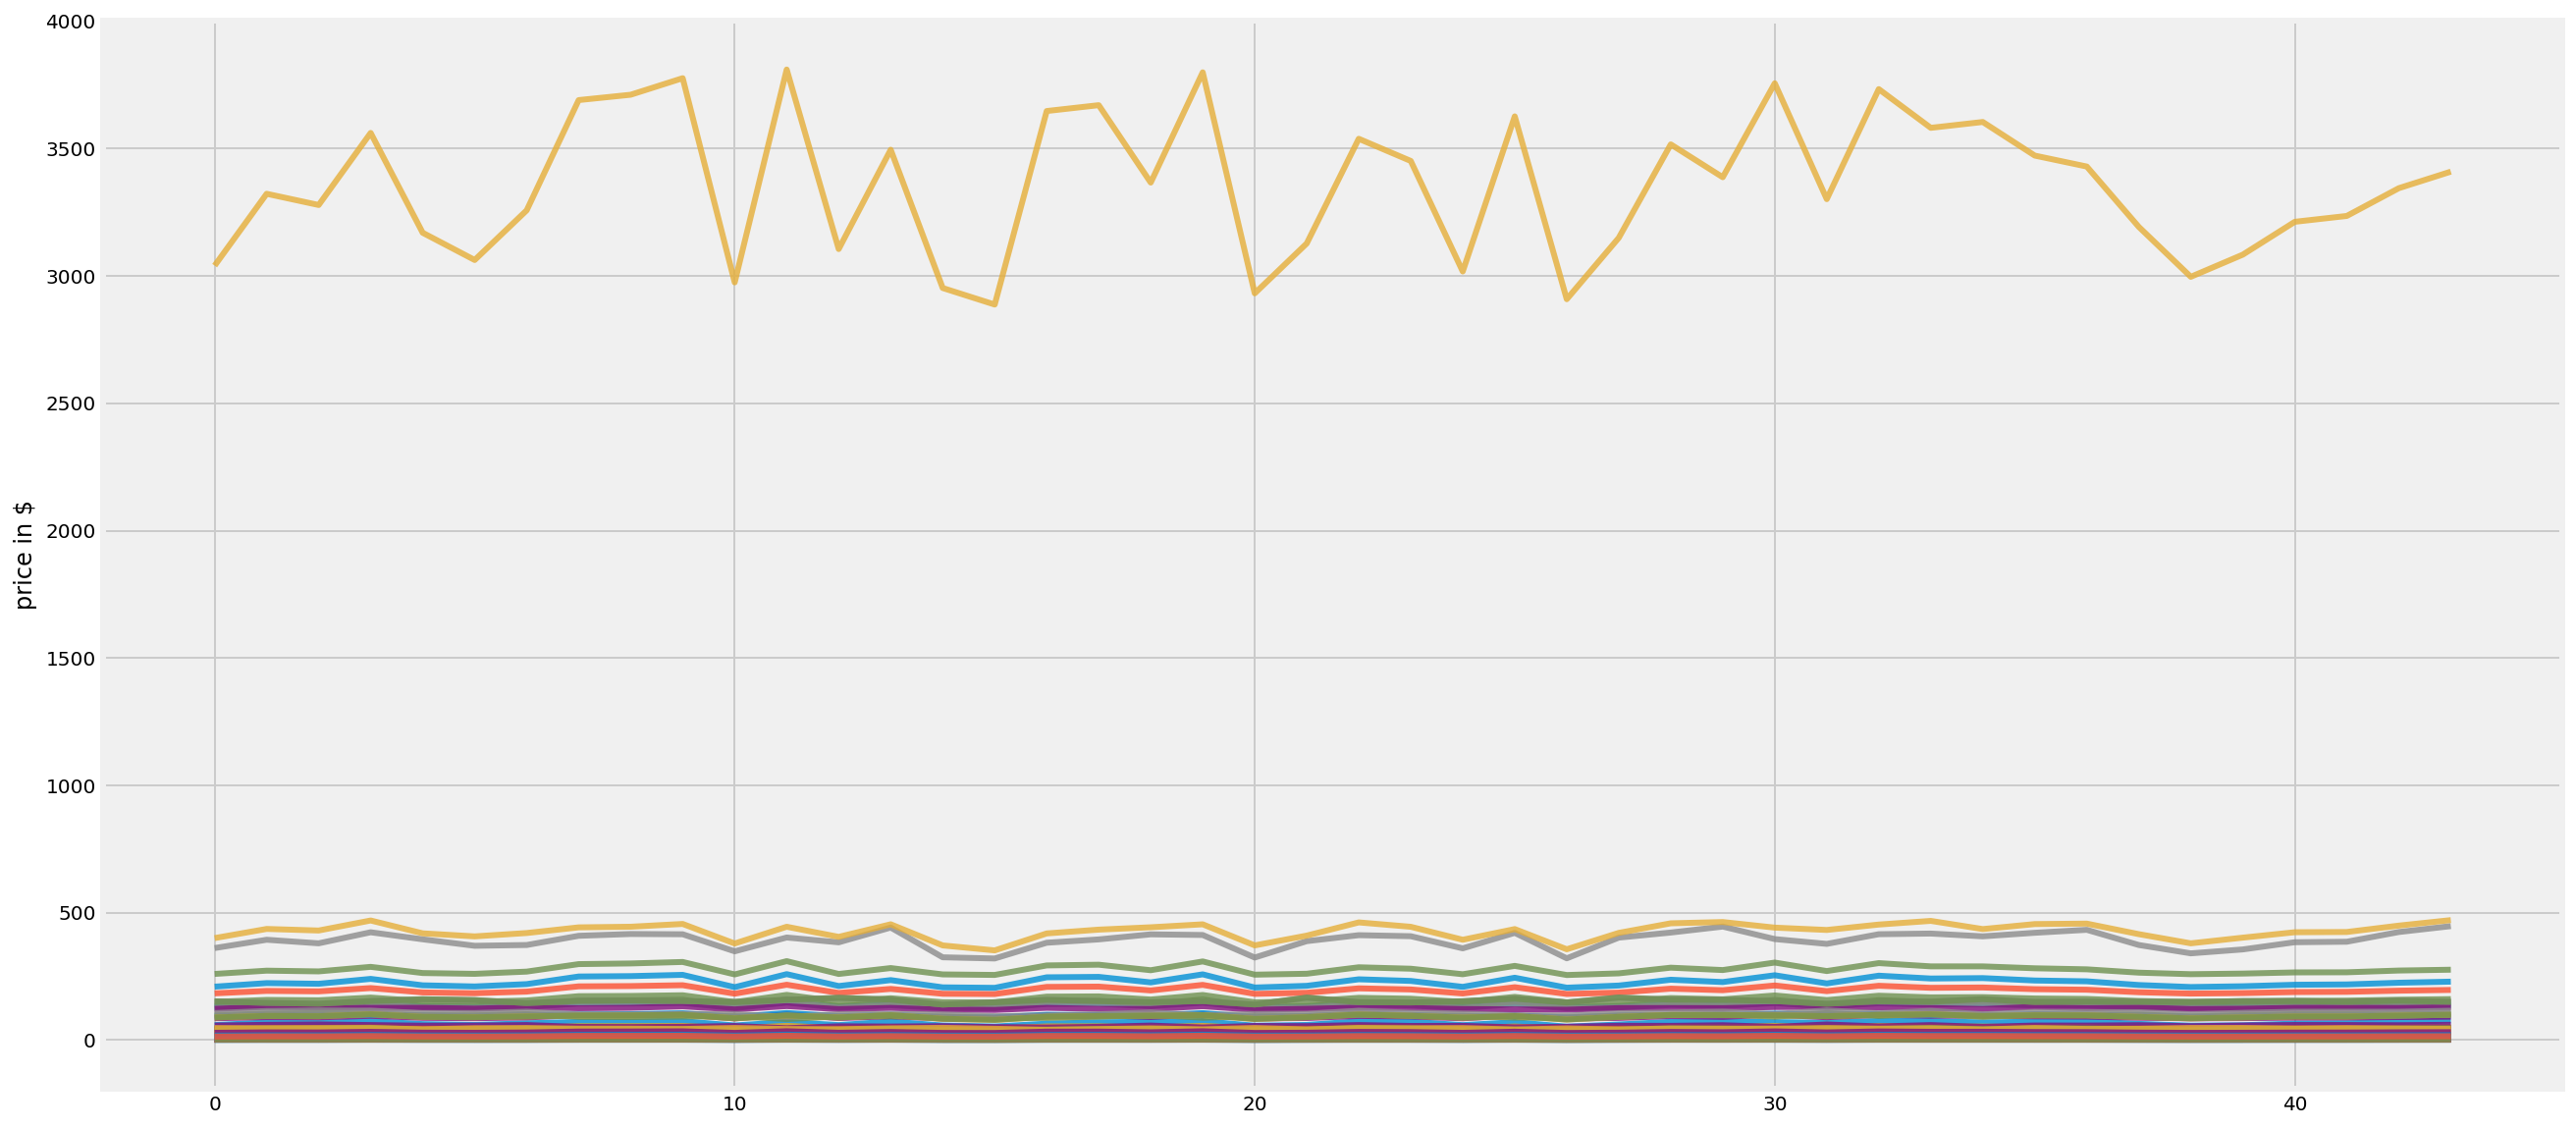

In [13]:
evolved_time_frame(index_portfolio_df.drop("operation_date"))

# me ahorro este paso, ya no es necesario pasarlo a pandas

In [14]:
monthly_data = index_portfolio_df.toPandas()
print("nuestros datos:", monthly_data.shape)
monthly_data

nuestros datos: (44, 214)


,operation_date,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,...,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414,operation_id
0,2016-08-31,58.549999,2.945098,2.035212,35.905201,31.810520,85.282547,25.197010,1.876392,1.640806,...,2.556591,4.512620,2.034337,16.239920,1.802321,18.541241,28.219740,17.248859,13.712550,3041
1,2017-09-29,68.820000,3.130105,2.120365,38.163296,33.868587,89.588615,26.791433,1.994932,1.737730,...,2.729725,4.783130,2.135204,16.968140,1.893236,19.356005,29.990978,18.381804,14.583611,3323
2,2017-07-31,67.279999,3.096271,2.103703,37.751171,33.494114,88.781967,26.501158,1.973283,1.719504,...,2.694991,4.730646,2.116312,16.818050,1.875990,19.188711,29.644960,18.165277,14.433984,3279
3,2018-08-31,73.809998,3.339781,2.225583,40.734421,36.167583,94.635925,28.611477,2.129692,1.854072,...,2.922104,5.103075,2.246852,17.929489,2.001116,20.357080,32.005886,19.579466,15.565989,3562
4,2017-02-28,62.419998,3.016724,2.065439,36.769798,32.583721,86.848732,25.813061,1.921777,1.675734,...,2.622276,4.612155,2.069136,16.481119,1.835318,18.798750,28.881130,17.707260,14.047240,3170
5,2016-09-30,59.099998,2.954642,2.038592,36.019180,31.910669,85.472832,25.278910,1.882257,1.644658,...,2.565762,4.524696,2.038403,16.267969,1.805881,18.576799,28.305981,17.294609,13.755130,3063
6,2017-06-30,65.489998,3.078991,2.095150,37.540806,33.304249,88.367615,26.352228,1.962138,1.709988,...,2.679030,4.704463,2.107064,16.754129,1.867054,19.104038,29.477554,18.069014,14.353306,3258
7,2019-02-28,71.029999,3.465994,2.288969,42.312374,37.569260,97.688545,29.711111,2.211232,1.924370,...,3.034441,5.285303,2.313338,18.507830,2.066243,20.978857,33.181908,20.217333,16.158705,3691
8,2019-03-29,72.150002,3.486272,2.299090,42.576355,37.795174,98.178474,29.890137,2.224480,1.935630,...,3.055223,5.316289,2.324066,18.598980,2.076780,21.081055,33.397682,20.354139,16.268244,3712
9,2019-06-28,73.709999,3.550183,2.330381,43.409660,38.508373,99.724998,30.454344,2.266239,1.971495,...,3.117659,5.414115,2.357497,18.889191,2.109442,21.397818,34.063446,20.775288,16.557648,3777


In [ ]:
#test_pd = monthly_data.drop(['operation_date', 'operation_id'], axis=1).pct_change(1).fillna(0)

In [ ]:
#test_dask = dd.from_pandas(test_pd, npartitions=3)

In [ ]:
#test_dask.corr().compute()

In [ ]:
#dd.from_pandas((monthly_data.drop(['operation_date', 'operation_id'], axis=1)), npartitions=3).corr().compute()

In [ ]:
# test

operate_cols = index_portfolio_df.remove_element(['operation_date', 'operation_id'])
pct_change_df = index_portfolio_df.pct_change(pct_cols=operate_cols, order_by="operation_date").na.fill(0)

In [ ]:
pct_benchmark_month = pct_change_df.select('MXWDU_Index')
print(pct_benchmark_month.shape)
pct_benchmark_month.show(5, False)

In [ ]:
import dask.dataframe as dd
import dask.array as da

from pyspark.sql import DataFrame

In [ ]:
import os

In [ ]:
def __spark_to_dask(self):
    tmp_path = os.getcwd() + '/data/tmp/'
    self.coalesce(1).write.mode('overwrite').parquet(tmp_path)
    return dd.read_parquet(tmp_path)

def add_to_series():
    def spark_to_series(self, column_series):
        dask_df = __spark_to_dask(self)
        series = dask_df[column_series]
        list_dask = series.to_delayed()
        full = [da.from_delayed(i, i.compute().shape, i.compute().dtype) for i in list_dask]
        return da.concatenate(full)
    DataFrame.toPandasSeries = spark_to_series
    
def add_to_numpy():
    def spark_to_numpy(self, column_series):
        add_to_series()
        dask_array = self.toPandasSeries(column_series)
        return da.from_array(dask_array.compute())
    DataFrame.toNumpyArray = spark_to_numpy

In [ ]:
add_to_series()
add_to_numpy()

In [ ]:
#pct_benchmark_month.toPandasSeries('MXWDU_Index').compute()

In [ ]:
#pct_benchmark_month.toNumpyArray('MXWDU_Index').compute()

In [71]:
## Lo mismo hacemos, pero para el resto de variables equity,
## seleccionamos la primera columna y lo convertimos a vector, esta columna representa el indice que estamos analizando, 
## 'MXWDU_Index', la idea es medir esta columna con el resto, ya que las demás son acciones que forman parte de ese índice.

investment_universe_month = monthly_data.sort_values('operation_date').drop(['operation_id', "operation_date"], axis = 1)

# nuestros datos
print(investment_universe_month.shape)
investment_universe_month

(44, 212)


,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,INVEXGU,...,HSBC-80,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414
15,52.860001,2.883770,2.015131,35.178982,31.169769,84.121132,24.680389,1.838127,1.617455,147.277298,...,1.43480,2.497090,4.425289,2.012394,16.062031,1.777677,18.329241,27.668961,16.917130,13.431810
26,52.200001,2.891846,2.016843,35.265209,31.221399,84.256142,24.745430,1.843074,1.620235,147.542206,...,1.45049,2.505682,4.435736,2.014991,16.054190,1.779171,18.346180,27.712021,16.936569,13.463880
20,56.060001,2.900382,2.019683,35.369720,31.323650,84.430229,24.817570,1.848704,1.623486,147.858200,...,1.47719,2.517362,4.448667,2.019527,16.095720,1.783234,18.379021,27.806660,17.012400,13.509610
14,56.810001,2.908540,2.022532,35.466530,31.424021,84.577118,24.884239,1.853805,1.626434,148.146698,...,1.47523,2.522300,4.459921,2.021708,16.124140,1.787010,18.410130,27.884291,17.061760,13.546310
10,57.000000,2.917284,2.025423,35.572048,31.511230,84.739281,24.958860,1.858902,1.629770,148.469604,...,1.50665,2.525776,4.471095,2.023689,16.125910,1.789778,18.440599,27.940790,17.078501,13.583850
38,56.230000,2.925575,2.028237,35.672359,31.613371,84.895119,25.030230,1.864202,1.632949,148.774597,...,1.50891,2.540164,4.483688,2.027372,16.171379,1.793637,18.468620,28.037430,17.156370,13.626800
24,58.349998,2.934595,2.031284,35.776989,31.694250,85.073196,25.107630,1.869680,1.636587,149.117706,...,1.55303,2.550953,4.496802,2.030811,16.197750,1.796955,18.498730,28.125151,17.209530,13.664360
0,58.549999,2.945098,2.035212,35.905201,31.810520,85.282547,25.197010,1.876392,1.640806,149.517105,...,1.56606,2.556591,4.512620,2.034337,16.239920,1.802321,18.541241,28.219740,17.248859,13.712550
5,59.099998,2.954642,2.038592,36.019180,31.910669,85.472832,25.278910,1.882257,1.644658,149.881699,...,1.58047,2.565762,4.524696,2.038403,16.267969,1.805881,18.576799,28.305981,17.294609,13.755130
39,57.970001,2.965716,2.042937,36.151321,32.034592,85.712433,25.374029,1.889264,1.649300,150.318298,...,1.55973,2.574640,4.541207,2.043536,16.306400,1.810993,18.619970,28.418051,17.372351,13.806210


In [72]:
## (t+1 / t)-1
## (precio_hoy / precio_ayer)-1

pct_investment_month = investment_universe_month.pct_change(1)

# nuestros datos
print(pct_investment_month.shape)
pct_investment_month

(44, 212)


,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,INVEXGU,...,HSBC-80,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414
15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,-0.012486,0.002800,0.000850,0.002451,0.001656,0.001605,0.002635,0.002691,0.001719,0.001799,...,0.010935,0.003441,0.002361,0.001291,-0.000488,0.000840,0.000924,0.001556,0.001149,0.002388
20,0.073946,0.002952,0.001408,0.002964,0.003275,0.002066,0.002915,0.003055,0.002007,0.002142,...,0.018408,0.004661,0.002915,0.002251,0.002587,0.002284,0.001790,0.003415,0.004477,0.003397
14,0.013379,0.002813,0.001411,0.002737,0.003204,0.001740,0.002686,0.002759,0.001816,0.001951,...,-0.001327,0.001962,0.002530,0.001080,0.001766,0.002118,0.001693,0.002792,0.002901,0.002717
10,0.003344,0.003006,0.001429,0.002975,0.002775,0.001917,0.002999,0.002749,0.002051,0.002180,...,0.021298,0.001378,0.002505,0.000980,0.000110,0.001549,0.001655,0.002026,0.000981,0.002771
38,-0.013509,0.002842,0.001389,0.002820,0.003241,0.001839,0.002859,0.002851,0.001951,0.002054,...,0.001500,0.005697,0.002816,0.001820,0.002820,0.002156,0.001520,0.003459,0.004560,0.003162
24,0.037702,0.003083,0.001502,0.002933,0.002558,0.002098,0.003092,0.002939,0.002228,0.002306,...,0.029240,0.004247,0.002925,0.001696,0.001631,0.001850,0.001630,0.003129,0.003098,0.002756
0,0.003428,0.003579,0.001934,0.003584,0.003669,0.002461,0.003560,0.003590,0.002578,0.002678,...,0.008390,0.002210,0.003518,0.001736,0.002603,0.002986,0.002298,0.003363,0.002285,0.003527
5,0.009394,0.003241,0.001661,0.003174,0.003148,0.002231,0.003250,0.003126,0.002348,0.002438,...,0.009201,0.003587,0.002676,0.001999,0.001727,0.001975,0.001918,0.003056,0.002652,0.003105
39,-0.019120,0.003748,0.002131,0.003669,0.003883,0.002803,0.003763,0.003723,0.002823,0.002913,...,-0.013123,0.003460,0.003649,0.002518,0.002362,0.002831,0.002324,0.003959,0.004495,0.003713


In [73]:
## el vector de percentage change se convierte a un arreglo numpy de dimensión (147,70)

pct_investment_month_array = np.array(pct_investment_month.drop('MXWDU_Index', axis=1))
#_pct_investment_month_array = np.array(_pct_investment_month)

# nuestros datos
print(pct_investment_month_array.shape)
print(pct_investment_month_array)

(44, 211)
[[       nan        nan        nan ...        nan        nan        nan]
 [0.00280046 0.0008496  0.00245106 ... 0.00155628 0.00114906 0.00238752]
 [0.00295174 0.0014081  0.00296354 ... 0.00341511 0.00447726 0.00339651]
 ...
 [0.00564063 0.00415337 0.0059669  ... 0.00704992 0.00697923 0.00527787]
 [0.0065999  0.00487864 0.00703335 ... 0.00742412 0.00678837 0.00645554]
 [0.00301039 0.00221634 0.00319064 ... 0.00515819 0.0050844  0.00369799]]


In [74]:
pct_benchmark_month_array = np.array(pct_investment_month['MXWDU_Index'])
print(pct_benchmark_month_array.shape)
print(pct_benchmark_month_array)

(44,)
[        nan -0.01248581  0.07394636  0.01337852  0.00334446 -0.01350877
  0.03770226  0.00342761  0.00939366 -0.01912009  0.01035016  0.01024412
  0.0290688   0.02512726  0.01345723  0.01612395  0.02209082 -0.00319633
  0.02733243  0.00401314  0.01880084  0.02150542  0.02019912  0.00515888
  0.05701209 -0.04475061 -0.01497464  0.00404464  0.00472293 -0.01672887
  0.03065242  0.00695764  0.00609679 -0.07433347  0.01585691 -0.08119716
  0.08042387  0.02466819  0.01576803  0.03423425 -0.06070768  0.05164793
  0.00067837 -0.04718008]


In [75]:
## creamos arreglos numpy con dimensiones X+1 = 148, rellenas de ceros, para ser imputados con nuevos vectores

up_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
down_month = np.zeros((pct_benchmark_month_array.shape[0]+1, 1))
up_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))
down_move = np.zeros((pct_benchmark_month_array.shape[0]+1, pct_investment_month_array.shape[1]))

print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [76]:
## rellenamos las matrices de ceros con valores que aprueben las condiciones, 
## se realiza una comparación dentro de los arreglos de porcentajes de cambio, 
## sí alguno de esos porcentajes es superior a 0, entonces entra a los arreglos 
## de movimientos positivos (incrementos), pero sí alguno es menor que 0, entonces
## el porcentaje se almacena en los arreglos de movimientos negativos (decrementos).

## Básicamente, se separan los porcentajes de cambio en dos matrices: 
## matriz de positivos cuando el porcentaje es > 0 
## matriz de negativos cuando el porcentaje es <= 0

size_benchmark_matrix = pct_benchmark_month_array.shape[0]
for i in range (1, size_benchmark_matrix):
    if pct_benchmark_month_array[i] > 0:
        up_month[i] = pct_benchmark_month_array[i]
        up_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]
    else:
        down_month[i] = pct_benchmark_month_array[i]
        down_move[i] = pct_investment_month_array[i, 0:pct_investment_month_array.shape[1]]
        
print(up_month.shape)
print(down_month.shape)
print(up_move.shape)
print(down_move.shape)

(45, 1)
(45, 1)
(45, 211)
(45, 211)


In [ ]:
down_move

In [77]:
## calculamos los vectores 'peor más alto' y 'mejor más alto'

np.seterr(divide='ignore', invalid='ignore')
greater_worse = down_move / down_month
greater_better = (up_move / up_month) * float(-1.0)

print(greater_worse.shape)
print(greater_better.shape)

(45, 211)
(45, 211)


In [78]:
## ambos vectores los convertimos a pandas dataframes, y solo nos quedamos con los vectores que tengan valores != np.nan
## una de las ventajas de los pandas dataframes es que mantienen un ídince único por row, esto lo hace poder separarse, y juntarse
## en cuantos sub-conjuntos se requieran y siempre se podrá mantener un órden.

greater_worse_df = pd.DataFrame(data=greater_worse).dropna()
greater_better_df = pd.DataFrame(data=greater_better).dropna()

print(greater_worse_df.shape)
print(greater_better_df.shape)

(11, 211)
(32, 211)


In [82]:
## calculamos ahora, la mediana acumulada con los pandas dataframes que construimos, 
## con un periodo mínimo (método expanding) de al menos 1 observación dada.

median_down = greater_worse_df.expanding().median()
median_up = greater_better_df.expanding().median()

print(median_down.shape)
print(median_up.shape)

(11, 211)
(32, 211)


In [83]:
#greater_worse_df.expanding().cov()

In [84]:
# se transponen ambos pandas df por la columna periodos, columna que almacena números no consecutivos desde 1 hasta 147

down_transpose = median_down.T
up_transpose = median_up.T

print(down_transpose.shape)
print(up_transpose.shape)

(211, 11)
(211, 32)


In [85]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_down

ranked_down = down_transpose.rank(method='first')
transpose_ranked_down = ranked_down.T

print(ranked_down.shape)
print(transpose_ranked_down.shape)

(211, 11)
(11, 211)


In [86]:
# se rankean los resultados (top 10) entre las fechas cierre (periodo) y se vuelve a transponer la tabla ranked_up

ranked_up = up_transpose.rank(method='first')
transpose_ranked_up = ranked_up.T

print(ranked_up.shape)
print(transpose_ranked_up.shape)

(211, 32)
(32, 211)


In [87]:
transpose_ranked_up

,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
2,141.0,182.0,140.0,118.0,171.0,143.0,135.0,172.0,169.0,147.0,...,43.0,96.0,146.0,167.0,159.0,164.0,176.0,113.0,99.0,115.0
3,111.0,162.0,118.0,86.0,156.0,121.0,117.0,155.0,149.0,124.0,...,160.0,139.0,130.0,169.0,153.0,146.0,159.0,102.0,90.0,113.0
4,104.0,169.0,115.0,83.0,161.0,123.0,112.0,158.0,156.0,131.0,...,76.0,155.0,139.0,181.0,193.0,150.0,164.0,109.0,94.0,118.0
6,129.0,192.0,145.0,115.0,185.0,142.0,141.0,181.0,178.0,156.0,...,69.0,166.0,161.0,200.0,205.0,177.0,188.0,133.0,120.0,152.0
7,121.0,179.0,132.0,104.0,174.0,139.0,129.0,172.0,170.0,146.0,...,53.0,169.0,153.0,188.0,196.0,165.0,176.0,126.0,113.0,135.0
8,110.0,191.0,115.0,99.0,172.0,113.0,121.0,168.0,165.0,135.0,...,47.0,133.0,148.0,187.0,202.0,171.0,178.0,127.0,140.0,129.0
10,119.0,177.0,124.0,143.0,145.0,104.0,114.0,142.0,135.0,116.0,...,51.0,182.0,152.0,171.0,205.0,185.0,191.0,155.0,159.0,131.0
11,117.0,184.0,124.0,137.0,161.0,101.0,118.0,151.0,146.0,115.0,...,51.0,149.0,156.0,172.0,201.0,178.0,189.0,145.0,159.0,130.0
12,111.0,184.0,117.0,141.0,143.0,96.0,106.0,137.0,130.0,108.0,...,57.0,181.0,153.0,174.0,199.0,190.0,200.0,157.0,162.0,126.0
13,106.0,189.0,118.0,131.0,166.0,99.0,107.0,136.0,158.0,113.0,...,64.0,170.0,153.0,181.0,205.0,186.0,203.0,140.0,150.0,126.0


In [88]:
## se añade variable 'label' con la idea de que al juntar ambos dataframes se puedan distinguir los 'worse' de los 'better'
## y se unen ambos dataframes con la etiqueta creada, se usó el método 'insert' por lo que no se deberá correr de nuevo, una
## vez ejecutado ya que fallará por duplicidad de columnas.

worse_better_pd = pd.concat([transpose_ranked_up, transpose_ranked_down]).sort_index()
print(worse_better_pd.shape)
worse_better_pd

(43, 211)


,0,1,2,3,4,5,6,7,8,9,...,201,202,203,204,205,206,207,208,209,210
1,97.0,169.0,113.0,147.0,150.0,102.0,99.0,144.0,140.0,116.0,...,45.0,91.0,122.0,158.0,185.0,172.0,167.0,154.0,163.0,119.0
2,141.0,182.0,140.0,118.0,171.0,143.0,135.0,172.0,169.0,147.0,...,43.0,96.0,146.0,167.0,159.0,164.0,176.0,113.0,99.0,115.0
3,111.0,162.0,118.0,86.0,156.0,121.0,117.0,155.0,149.0,124.0,...,160.0,139.0,130.0,169.0,153.0,146.0,159.0,102.0,90.0,113.0
4,104.0,169.0,115.0,83.0,161.0,123.0,112.0,158.0,156.0,131.0,...,76.0,155.0,139.0,181.0,193.0,150.0,164.0,109.0,94.0,118.0
5,96.0,167.0,113.0,132.0,152.0,105.0,102.0,150.0,148.0,123.0,...,56.0,76.0,119.0,157.0,169.0,161.0,165.0,130.0,101.0,104.0
6,129.0,192.0,145.0,115.0,185.0,142.0,141.0,181.0,178.0,156.0,...,69.0,166.0,161.0,200.0,205.0,177.0,188.0,133.0,120.0,152.0
7,121.0,179.0,132.0,104.0,174.0,139.0,129.0,172.0,170.0,146.0,...,53.0,169.0,153.0,188.0,196.0,165.0,176.0,126.0,113.0,135.0
8,110.0,191.0,115.0,99.0,172.0,113.0,121.0,168.0,165.0,135.0,...,47.0,133.0,148.0,187.0,202.0,171.0,178.0,127.0,140.0,129.0
9,67.0,144.0,89.0,78.0,128.0,63.0,66.0,122.0,116.0,95.0,...,143.0,45.0,101.0,132.0,139.0,121.0,140.0,72.0,52.0,94.0
10,119.0,177.0,124.0,143.0,145.0,104.0,114.0,142.0,135.0,116.0,...,51.0,182.0,152.0,171.0,205.0,185.0,191.0,155.0,159.0,131.0


In [89]:
## se crea un índice 'closing_id' para cada registro, éste corre de [1:N+1] 
## con la idea de etiquetar el id del mes de registro de cierre,
## de la misma forma que lo anterior, NO se deberá ejecutar de nuevo; una vez hecho.

worse_better_pd['closing_id'] = range(1, len(worse_better_pd) + 1)
print(worse_better_pd.shape)
worse_better_pd

(43, 212)


,0,1,2,3,4,5,6,7,8,9,...,202,203,204,205,206,207,208,209,210,closing_id
1,97.0,169.0,113.0,147.0,150.0,102.0,99.0,144.0,140.0,116.0,...,91.0,122.0,158.0,185.0,172.0,167.0,154.0,163.0,119.0,1
2,141.0,182.0,140.0,118.0,171.0,143.0,135.0,172.0,169.0,147.0,...,96.0,146.0,167.0,159.0,164.0,176.0,113.0,99.0,115.0,2
3,111.0,162.0,118.0,86.0,156.0,121.0,117.0,155.0,149.0,124.0,...,139.0,130.0,169.0,153.0,146.0,159.0,102.0,90.0,113.0,3
4,104.0,169.0,115.0,83.0,161.0,123.0,112.0,158.0,156.0,131.0,...,155.0,139.0,181.0,193.0,150.0,164.0,109.0,94.0,118.0,4
5,96.0,167.0,113.0,132.0,152.0,105.0,102.0,150.0,148.0,123.0,...,76.0,119.0,157.0,169.0,161.0,165.0,130.0,101.0,104.0,5
6,129.0,192.0,145.0,115.0,185.0,142.0,141.0,181.0,178.0,156.0,...,166.0,161.0,200.0,205.0,177.0,188.0,133.0,120.0,152.0,6
7,121.0,179.0,132.0,104.0,174.0,139.0,129.0,172.0,170.0,146.0,...,169.0,153.0,188.0,196.0,165.0,176.0,126.0,113.0,135.0,7
8,110.0,191.0,115.0,99.0,172.0,113.0,121.0,168.0,165.0,135.0,...,133.0,148.0,187.0,202.0,171.0,178.0,127.0,140.0,129.0,8
9,67.0,144.0,89.0,78.0,128.0,63.0,66.0,122.0,116.0,95.0,...,45.0,101.0,132.0,139.0,121.0,140.0,72.0,52.0,94.0,9
10,119.0,177.0,124.0,143.0,145.0,104.0,114.0,142.0,135.0,116.0,...,182.0,152.0,171.0,205.0,185.0,191.0,155.0,159.0,131.0,10


In [90]:
## se transponen ambos dataframes, de antes tener una dimensión (68, 70), es decir; 
## 68 registros i.e. 'Rows' (variables)
## 70 columnas fijas (a menos que sea añadido otro asset desde el csv inicial)

## a tener una dimensión 'transpuesta' (invertída sí querés...) de (70, 68), es decir;
## 70 registros i.e. 'Rows' fijos (a menos que sea añadido otro asset desde el csv inicial)
## 68 columnas (variables)

In [91]:
asset_name_list = index_portfolio_df.drop('operation_id', "operation_date", "MXWDU_Index").columns
print(asset_name_list, '\n')

['SCOTIAG', 'AXESCP', 'BMERGOB', 'BMRGOB25', 'VALUEF4', 'BLKDIA7', 'BLKGUB1', 'GBMGUBL', 'INVEXGU', 'NTEGUB13', 'NTEGUB15', 'PRINFGU', 'ST&ER1X', 'STERGOB', 'SURCETE', 'VECTPRE', 'FONDEO', 'SCOTIA1', 'BMERLIQ28', 'DINBUR1', 'FONSER130', 'GBMF2', 'INBUMAX', 'INVEXCP', 'ACTIREN', 'SUR1E', 'MONEX28', 'BLKDIN45', 'VECTRF48', 'NTEMP+50', 'SBANKCP', 'BMERLIQ52', 'BMERTES', 'BMRGOB254', 'BLKDIA55', 'BLKLIQ/A', 'BLKPLUSA', 'FONSER161', 'PYMES', 'ST&ER1P', 'STER10P', 'SUPER', 'INVEXDX', 'HSBCEMP69', 'VECTRF71', 'SCOTIA2', 'ACTIGOB74', 'AFIRPLU', 'AXESMP76', 'BLK1LIQA', 'HSBCMP83', 'INVEXMP85', 'NTEMP+86', 'PRINFMP88', 'PRINMAS89', 'VECTMD92', 'HSBCEMP93', 'ACTIMED', 'ALTERNA', 'GBMF3', 'GBMM3', 'HSBCCOR', 'NTEDP', 'NTEMP+105', 'SURCORP', 'FINDE1110', 'SBANKMP', 'INVEXMP117', 'DMEDIO', 'PRINFMP119', 'NTEMP+120', 'BONDDIA', 'PRINMAS125', 'AXESMP130', 'GBMGUB', 'SCOTILP', 'INBUREX', 'PRINGLP', 'SUR30E', 'SURBONO', 'AXESLP', 'SCOTLPG', 'SCOTIMB', 'NAFINTR', 'PRINFTR', 'STEREAL', 'SURUDI', 'FT/REAL'

In [92]:
## de pandas dataframes, una vez separados en dos conjuntos ['worse', 'better'],
## creamos por separado dos spark dataframes.

worse_better_df = spark.createDataFrame(worse_better_pd)
worse_better_df.show(5, False)

+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+-----+-----+-----+-----+----+-----+-----+----+----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+-----+-----+----+-----+----+-----+-----+-----+-----+----+----+----+----+----+----

In [93]:
mapping = dict(zip((worse_better_df.columns), asset_name_list))
mapped_name_df = worse_better_df.select([col(c).alias(mapping.get(c, c)) for c in worse_better_df.columns])
print(mapped_name_df.shape)
mapped_name_df.show(5, False)

(43, 212)
+-------+------+-------+--------+-------+-------+-------+-------+-------+--------+--------+-------+-------+-------+-------+-------+------+-------+---------+-------+---------+-----+-------+-------+-------+-----+-------+--------+--------+--------+-------+---------+-------+---------+--------+--------+--------+---------+-----+-------+-------+-----+-------+---------+--------+-------+---------+-------+--------+--------+--------+---------+--------+---------+---------+--------+---------+-------+-------+-----+-----+-------+-----+---------+-------+---------+-------+----------+------+----------+---------+-------+----------+---------+------+-------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+------+-------+-------+-------+-------+-------+----------+----------+----------+----------+-------+----------+----------+----------+----------+-------+-------+-------+------+-------+------+-------+-------+-------+-------+-------+-------+------+-------+-------+------+

In [ ]:
#mapped_name_df.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/RankMedian")

# Finish Rank Median Module

# Start TopAssetRank

In [94]:
worse_better = spark.read.parquet("data/ophelia/out/engine/RankMedian/")
print(worse_better.shape)

(43, 212)


In [95]:
## se crea un generador "shape long format", una lista con iteraciones, esta lista trabajará con dos variables principales,
## 1-. la variable 'equity_index', será la que contenga los 'id' de los activos
## 2-. la variable 'median_down', será la que contenga la mediana acumulada por cada activo.
## Se mantendrá a lo largo de la transformación 1 columna fija; 'closing_id',
## closing_id: variable que indica el mes de cierre y reporte de precio

def panel_format(df, pivot_col, new_columns: list = []):
    first_col = str(new_columns[0])
    second_col = str(new_columns[1])
    piv_col = [pivot_col]
    df_types = df.dtypes
    cols, dtype = zip(*[(c, t) for (c, t) in df_types if c not in piv_col])
    if len(set(dtype)) > 1:
        raise ValueError("Columns not the same data type...")
    generator_explode = explode(array([
        struct(lit(c).alias(first_col), col(c).alias(second_col)) for c in cols
    ])).alias("column_explode")
    column_to_explode = ["column_explode."+first_col, "column_explode."+second_col]
    panel_df = df.select(piv_col + [generator_explode])\
                 .select(piv_col + column_to_explode)
    return panel_df

In [ ]:
worse_better.show(5, False)

In [96]:
## se crea nuevo spark-dataframe donde solo se mostrará por partición ['closing_id'] 
## el top 10 mejores meses donde tuvo menos malos que el resto de los registros; ["top_rank"].
new_columns = ["ticker", "rank"]
asset_ranking_df = worse_better.transpose("closing_id", new_columns)
print(asset_ranking_df.shape)
asset_ranking_df.printSchema()
asset_ranking_df.show(10, False)

(9073, 3)
root
 |-- closing_id: long (nullable = true)
 |-- ticker: string (nullable = false)
 |-- rank: double (nullable = true)

+----------+--------+-----+
|closing_id|ticker  |rank |
+----------+--------+-----+
|1         |SCOTIAG |100.0|
|1         |AXESCP  |177.0|
|1         |BMERGOB |99.0 |
|1         |BMRGOB25|80.0 |
|1         |VALUEF4 |152.0|
|1         |BLKDIA7 |92.0 |
|1         |BLKGUB1 |95.0 |
|1         |GBMGUBL |124.0|
|1         |INVEXGU |149.0|
|1         |NTEGUB13|110.0|
+----------+--------+-----+
only showing top 10 rows



In [97]:
from pyspark.sql.functions import udf
from pyspark.sql.types import IntegerType
map_asset_id = dict(zip(asset_name_list, worse_better_df.columns))

In [98]:
from pyspark.sql.functions import col, create_map, lit
from itertools import chain

mapping_expr = create_map([lit(x) for x in chain(*map_asset_id.items())])

In [99]:
asset_rank_10 = asset_ranking_df.where(col("rank") <= 10).select('*', mapping_expr.getItem(col('ticker')).alias('ticker_id')).orderBy("closing_id", "rank")
asset_rank_10.coalesce(1).write.mode("overwrite").parquet("data/ophelia/out/engine/LongMedianRank")

In [100]:
asset_rank_10.show(5, False)

+----------+----------+----+---------+
|closing_id|ticker    |rank|ticker_id|
+----------+----------+----+---------+
|1         |SCOTEUR   |1.0 |150      |
|1         |STERDOW270|2.0 |136      |
|1         |STERDOW281|3.0 |142      |
|1         |BBVAE50   |4.0 |152      |
|1         |NTEGLA    |5.0 |148      |
+----------+----------+----+---------+
only showing top 5 rows



# Finish TopAssetRank

# Start TrainPortfolioSimulation

In [101]:
asset_rank_10_pd = pd.read_parquet("data/ophelia/out/engine/LongMedianRank/")
asset_rank_10_pd

,closing_id,ticker,rank,ticker_id
0,1,SCOTEUR,1.0,150
1,1,STERDOW270,2.0,136
2,1,STERDOW281,3.0,142
3,1,BBVAE50,4.0,152
4,1,NTEGLA,5.0,148
...,...,...,...,...
425,43,SCOTUSA,6.0,129
426,43,SURGLOB,7.0,149
427,43,ACTI500261,8.0,130
428,43,ACTI500272,9.0,137


In [ ]:
# buscar el asset_id de la matriz

In [42]:
investment_universe_month

,MXWDU_Index,SCOTIAG,AXESCP,BMERGOB,BMRGOB25,VALUEF4,BLKDIA7,BLKGUB1,GBMGUBL,INVEXGU,...,HSBC-80,FINDE1400,ACTIGOB401,AXESMP402,HSBCMP405,INVEXMP407,NAFFP28,PRINFMP410,PRINMAS411,VECTMD414
11,70.279999,3.584372,2.346940,43.854450,38.896275,100.548531,30.756266,2.288463,1.990646,177.089172,...,1.69984,3.150945,5.466560,2.375520,19.053101,2.126979,21.574129,34.493347,21.022665,16.726160
19,73.760002,3.573614,2.341750,43.714973,38.773052,100.289482,30.661377,2.281486,1.984640,176.626892,...,1.72485,3.140228,5.450255,2.369959,19.003691,2.121527,21.519873,34.316338,20.916319,16.664536
9,73.709999,3.550183,2.330381,43.409660,38.508373,99.724998,30.454344,2.266239,1.971495,175.617096,...,1.73542,3.117659,5.414115,2.357497,18.889191,2.109442,21.397818,34.063446,20.775288,16.557648
30,70.089996,3.530270,2.320742,43.152176,38.282108,99.248787,30.279200,2.253301,1.960369,174.763336,...,1.69622,3.096797,5.383591,2.346882,18.797131,2.099339,21.301645,33.824982,20.631298,16.470716
32,74.620003,3.508455,2.310057,42.867954,38.040977,98.721245,30.086843,2.239081,1.948144,173.821381,...,1.72630,3.075580,5.350233,2.335570,18.697701,2.088081,21.191652,33.592705,20.478479,16.366280
8,72.150002,3.486272,2.299090,42.576355,37.795174,98.178474,29.890137,2.224480,1.935630,172.856506,...,1.69701,3.055223,5.316289,2.324066,18.598980,2.076780,21.081055,33.397682,20.354139,16.268244
7,71.029999,3.465994,2.288969,42.312374,37.569260,97.688545,29.711111,2.211232,1.924370,171.982407,...,1.68623,3.034441,5.285303,2.313338,18.507830,2.066243,20.978857,33.181908,20.217333,16.158705
17,69.320000,3.446516,2.279260,42.060501,37.347698,97.219261,29.540045,2.198523,1.913564,171.138687,...,1.65986,3.014508,5.255394,2.303175,18.418070,2.056073,20.874922,32.974846,20.086849,16.053734
16,64.160004,3.424653,2.268312,41.782700,37.099503,96.703545,29.351105,2.184442,1.901630,170.192337,...,1.62195,2.996273,5.222013,2.291227,18.316339,2.044613,20.760530,32.750893,19.958578,15.944471
25,69.830002,3.402222,2.256999,41.504745,36.854721,96.154922,29.156509,2.170036,1.889017,169.197433,...,1.66627,2.968314,5.185336,2.279259,18.214590,2.032975,20.649658,32.535049,19.813156,15.839087


In [102]:
## lo que se pretende ahora, es obtener una matriz de dimensión (146, 10), es decir, 
## tener en cada row las fechas de cierre [closing_id],
## en cada columna (header) el número de ranking top 10 [top_rank],
## y en cada campo, el id del activo [asset_id].

pandas_df = asset_rank_10_pd.astype({'ticker_id':'int32'}) # le damos el tipo de dato int32 a la columna ticker
newselect = asset_rank_10_pd[["closing_id", "ticker_id"]] # seleccionamos solo estas dos columnas
num_of_assets = 10 # numero de assets que se crearan

indexed = np.zeros((investment_universe_month.shape[0], num_of_assets))

for q in range(1,investment_universe_month.shape[0]):
    selection = newselect.loc[pandas_df["closing_id"]==q]
    newselect_transpose = selection.T
    newpdf = newselect_transpose['ticker_id':].head()
    indexed[q] = newpdf

In [103]:
indexed = indexed[1:investment_universe_month.shape[0]+1]
index_row = indexed.astype(np.int64)
newrow = [0]*num_of_assets #np.zeros((1,num_of_assets))
index_row = np.vstack([index_row,newrow])
portfolio = np.zeros((investment_universe_month.shape[0], num_of_assets))

for r in range(0,investment_universe_month.shape[0]-1):
    s = r+1
    columns = index_row[s]
    portfolio[s] = pct_investment_month_array[s,[columns]]

In [104]:
means = portfolio[1:investment_universe_month.shape[0]-1]
performance = np.dot(portfolio,(1/num_of_assets))
returns = np.zeros((investment_universe_month.shape[0]-1,1))
equalw = np.zeros((investment_universe_month.shape[0]-1,1))
eweights = 1/(pct_investment_month_array.shape[1])
eweighted = np.dot(pct_investment_month_array,eweights)

for x in range (1,investment_universe_month.shape[0]):
    returns[x-1] = sum(performance[x])
    equalw[x-1] = sum(eweighted[x])

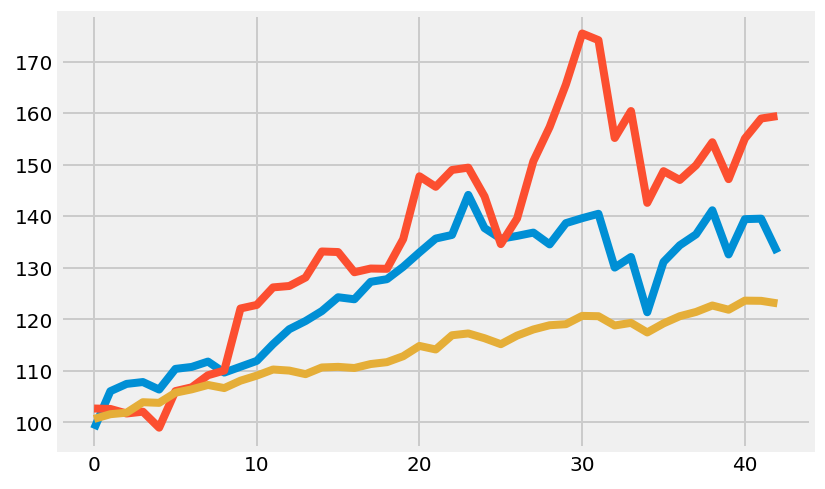

In [105]:
beg = 100
start = 100
commence = 100
bench = pct_benchmark_month_array[1:investment_universe_month.shape[0]]
bmk = np.zeros((investment_universe_month.shape[0],))
port = np.zeros((investment_universe_month.shape[0]-1,))
ew = np.zeros((investment_universe_month.shape[0]-1,))

for i in range (0,investment_universe_month.shape[0]-1):
    bmk[i] = beg*(1+bench[i])
    beg = bmk[i]
    port[i] = start*(1+returns[i])
    start = port[i]
    ew[i] = commence*(1+equalw[i])
    commence = ew[i]

plt.plot(bmk[0:investment_universe_month.shape[0]-1])
plt.plot(port)
plt.plot(ew)

In [106]:
index_row[index_row.shape[0]-2]

array([133, 139, 136, 142, 150, 129, 149, 130, 137, 145])

In [107]:
input_assets = index_row[index_row.shape[0]-2]
input_assets1 = pct_investment_month_array[:, input_assets]
dataframe = pd.DataFrame(input_assets1)
input_assets1 = dataframe.dropna()
mean_returns = input_assets1.mean()
covar_matrix = input_assets1.cov()
tickers = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

def calc_portfolio_perf(weights, mean_returns, cov, rf):
    portfolio_return = np.sum(mean_returns * weights) * 12
    portfolio_std = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sharpe_ratio = (portfolio_return - rf) / portfolio_std
    return portfolio_return, portfolio_std, sharpe_ratio

In [108]:
def simulate_random_portfolios(num_portfolios, mean_returns, cov, rf):
    results_matrix = np.zeros((len(mean_returns)+3, num_portfolios))
    for i in range(num_portfolios):
        weights = np.random.random(len(mean_returns))
        weights /= np.sum(weights)
        portfolio_return, portfolio_std, sharpe_ratio = calc_portfolio_perf(weights, mean_returns, cov, rf)
        results_matrix[0,i] = portfolio_return
        results_matrix[1,i] = portfolio_std
        results_matrix[2,i] = sharpe_ratio

        for j in range(len(weights)):
            results_matrix[j+3,i] = weights[j]

    results_df = pd.DataFrame(results_matrix.T, columns=['ret','stdev','sharpe'] + [ticker for ticker in tickers])

    return results_df

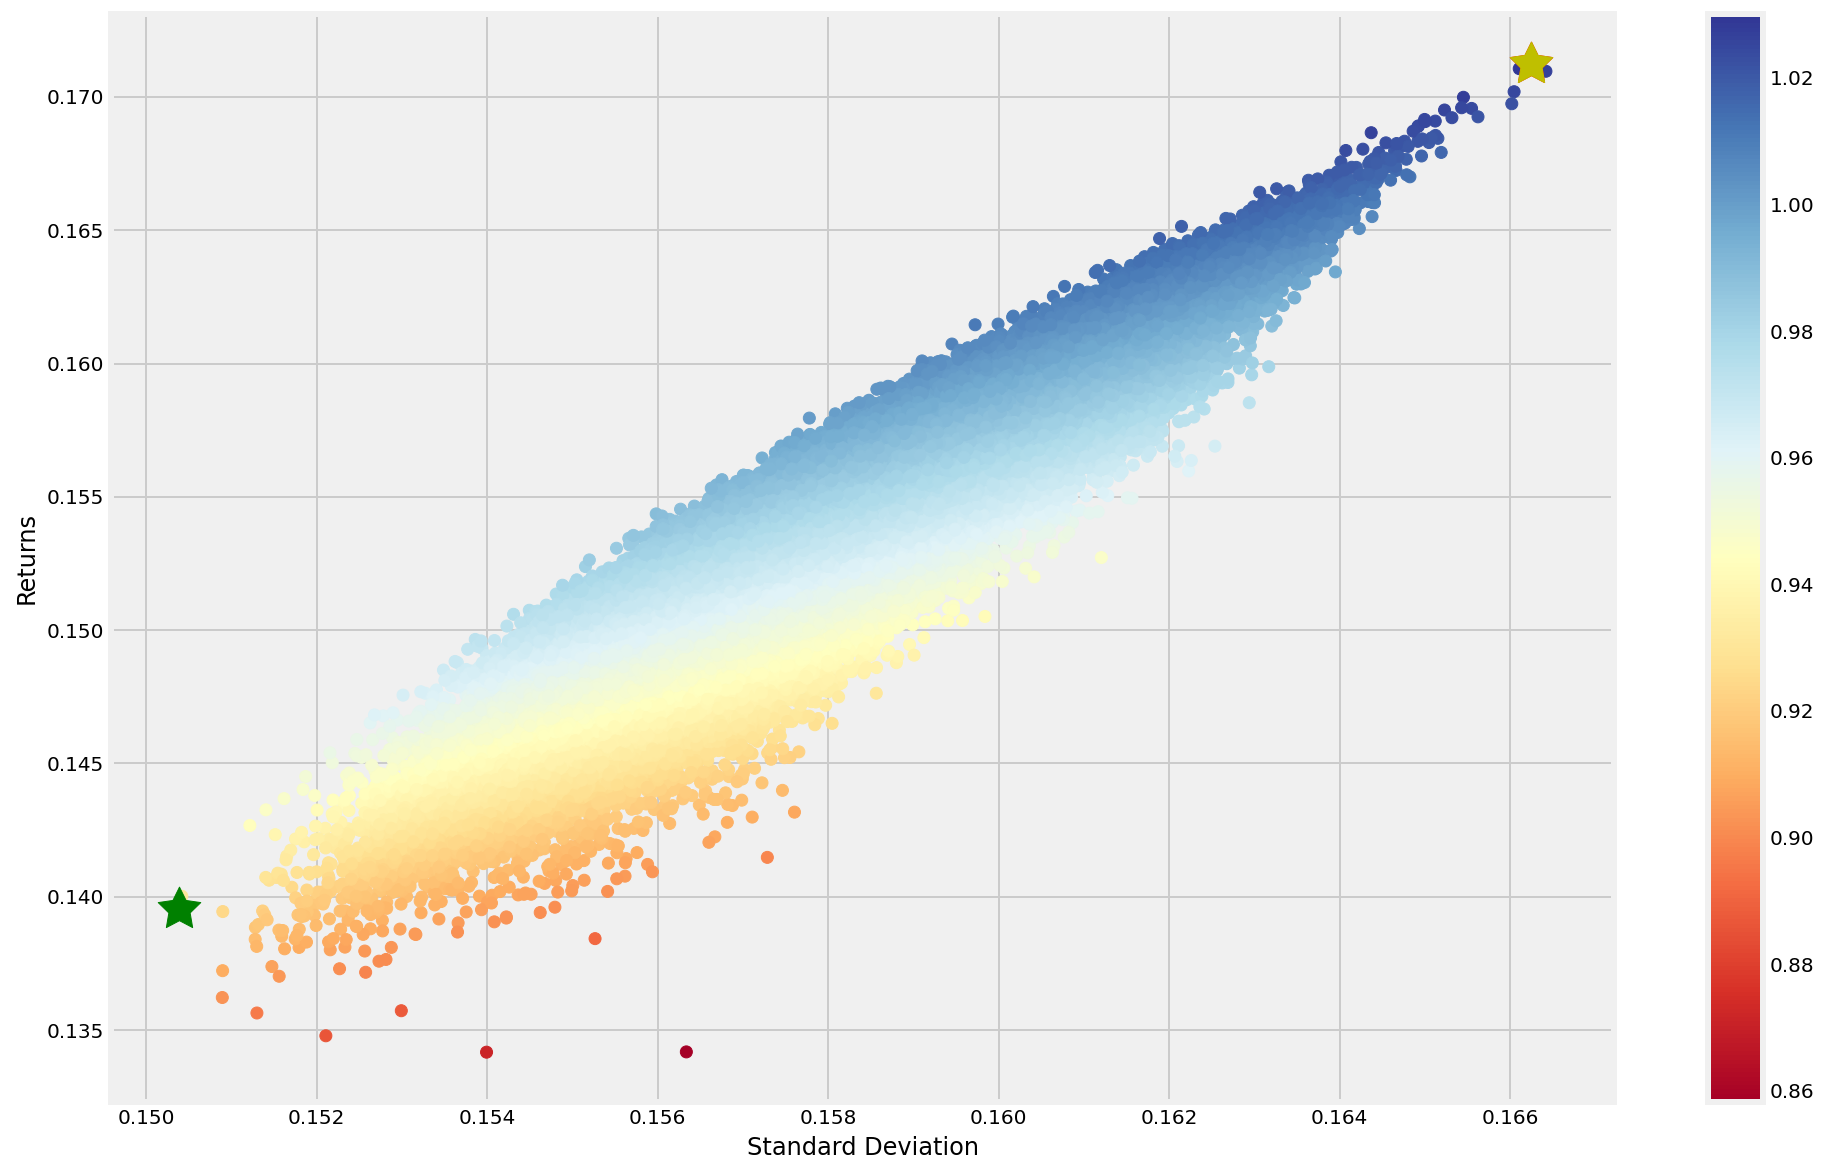

In [109]:
# TODO: revisar la sobrecarga de memoria en los stages marcados

mean_returns = input_assets1.mean()
cov = input_assets1.cov()
num_portfolios = 210000
rf = 0.0

results_frame = simulate_random_portfolios(num_portfolios, mean_returns, cov, rf)

max_sharpe_port = results_frame.iloc[results_frame['sharpe'].idxmax()]

min_vol_port = results_frame.iloc[results_frame['stdev'].idxmin()]

max_return_port = results_frame.iloc[results_frame['ret'].idxmax()]

plt.subplots(figsize=(15, 10))
plt.scatter(results_frame.stdev, results_frame.ret, c=results_frame.sharpe, cmap='RdYlBu')
plt.xlabel('Standard Deviation')
plt.ylabel('Returns')
plt.colorbar()
plt.scatter(max_sharpe_port['stdev'], max_sharpe_port['ret'], marker=(5,1,0), color='r', s=500)
plt.scatter(min_vol_port['stdev'], min_vol_port['ret'], marker=(5,1,0), color='g', s=500)
plt.scatter(max_return_port['stdev'], max_return_port['ret'], marker=(5,1,0), color='y', s=500)
plt.show()

In [49]:
results_frame

,ret,stdev,sharpe,0,1,2,3,4,5,6,7,8,9
0,-0.120336,0.153865,-0.782089,0.029656,0.058734,0.012051,0.089330,0.162252,0.180073,0.141221,0.149284,0.052294,0.125106
1,-0.116793,0.153909,-0.758845,0.020309,0.017332,0.128246,0.074680,0.215089,0.136263,0.148293,0.120121,0.058479,0.081187
2,-0.119604,0.152671,-0.783407,0.051146,0.042775,0.089625,0.044317,0.140159,0.202540,0.142781,0.058072,0.041281,0.187305
3,-0.125439,0.156995,-0.798998,0.047751,0.109509,0.109856,0.127204,0.112849,0.002820,0.111043,0.189816,0.163123,0.026029
4,-0.121769,0.154272,-0.789317,0.054478,0.112690,0.133702,0.085342,0.141614,0.035284,0.102718,0.101413,0.086950,0.145808
...,...,...,...,...,...,...,...,...,...,...,...,...,...
209995,-0.122799,0.153253,-0.801283,0.037321,0.150849,0.122955,0.022561,0.111878,0.163886,0.051334,0.029661,0.056635,0.252920
209996,-0.126112,0.156870,-0.803924,0.135606,0.147151,0.058408,0.072711,0.151849,0.148077,0.163598,0.074035,0.014401,0.034163
209997,-0.124068,0.155804,-0.796311,0.152595,0.059475,0.131487,0.094284,0.152530,0.106623,0.058334,0.003777,0.137438,0.103456
209998,-0.123779,0.155863,-0.794154,0.180356,0.010852,0.095493,0.091784,0.167340,0.115779,0.021782,0.124742,0.075762,0.116110


In [50]:
renamed_columns = {
    0: 'fund_w_zero',
    1: 'fund_w_one',
    2: 'fund_w_two',
    3: 'fund_w_three',
    4: 'fund_w_four',
    5: 'fund_w_five',
    6: 'fund_w_six',
    7: 'fund_w_seven',
    8: 'fund_w_eight',
    9: 'fund_w_nine'
}
results_frame_renamed = results_frame.rename(columns=renamed_columns)
results_frame_renamed.to_csv('data/ophelia/out/model/tmp/TrainSimulation.csv', encoding='utf-8', index=False)

In [51]:
def pd_series_to_dict(pd_series):
    to_python_dict = dict(pd_series)
    return {str(k): float(v) for k, v in to_python_dict.items()}

In [52]:
def key_map_rename(dic, new_key, old_key):
    for key in range(len(old_key)):
        dic[new_key[key]] = dic.pop(old_key[key])
    return dic

In [53]:
def persist_metadata_model(dic_sample, json_name):
    dict_to_json = spark.read.json(sc.parallelize([dic_sample]))
    dict_to_json.coalesce(1).write.mode("overwrite").json("data/ophelia/out/model/model_info/"+str(json_name))

In [54]:
max_return_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['ret'].idxmax()])
persist_metadata_model(max_return_port_sample, "maxReturnTrainWeights")

In [55]:
max_sharpe_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['sharpe'].idxmax()])
persist_metadata_model(max_sharpe_port_sample, "maxSharpeTrainWeights")

In [56]:
min_vol_port_sample = pd_series_to_dict(results_frame_renamed.iloc[results_frame_renamed['stdev'].idxmax()])
persist_metadata_model(min_vol_port_sample, "minVolatileTrainWeights")

# Finish TrainPortfolioSimulation

# Start EfficientFrontier

In [57]:
import json

def json_read(json_path):
    with open(json_path) as json_file:
        return(json.load(json_file))

In [59]:
json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights/part-00000-ed8b0ffa-07d2-4fb7-8fa9-54b0a14eed09-c000.json'
min_vol_port_sample = json_read(json_p)
min_vol_port_sample

{'fund_w_eight': 0.030446909696649548,
 'fund_w_five': 0.10773641012463936,
 'fund_w_four': 0.0018374150433648317,
 'fund_w_nine': 0.022333535209090073,
 'fund_w_one': 0.33889721194856565,
 'fund_w_seven': 0.12473837211171095,
 'fund_w_six': 0.06728126521745104,
 'fund_w_three': 0.004989767906381945,
 'fund_w_two': 0.012553070829607988,
 'fund_w_zero': 0.28918604191253855,
 'ret': -0.14307624791143753,
 'sharpe': -0.8690858832348529,
 'stdev': 0.1646284339343872}

In [ ]:
#json_p = 'data/ophelia/out/model/model_info/minVolatileTrainWeights/part-00000-6a7870c6-f591-4274-92c9-d1fa36fd0813-c000.json'
#min_vol_port_sample = json_read(json_p)
#min_vol_port_sample

In [60]:
results_spark_df = spark.read.csv("data/ophelia/out/model/tmp/TrainSimulation.csv", header='true', inferSchema=True)
results_spark_df.show(5, False)
results_spark_df.describe().show(10, False)
results_spark_df.printSchema()

+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|ret                 |stdev              |sharpe             |fund_w_zero         |fund_w_one         |fund_w_two          |fund_w_three        |fund_w_four        |fund_w_five          |fund_w_six         |fund_w_seven        |fund_w_eight        |fund_w_nine         |
+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+
|-0.12033620657035038|0.15386503665079274|-0.7820893504445826|0.029655610544278625|0.05873411828140106|0.012050849899143108|0.08932991980269187 |0.16225169055822988|0.1800733058282388   |

In [61]:
from pyspark.sql.functions import monotonically_increasing_id, current_date, current_timestamp
from pyspark.ml.feature import QuantileDiscretizer

results_index = results_spark_df.select("*", 
                                        (monotonically_increasing_id() + 1000).alias("portfolio_id"),
                                        current_date().alias("information_date"),
                                        current_timestamp().alias("model_date"))
results_index.show(5, False)

+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+
|ret                 |stdev              |sharpe             |fund_w_zero         |fund_w_one         |fund_w_two          |fund_w_three        |fund_w_four        |fund_w_five          |fund_w_six         |fund_w_seven        |fund_w_eight        |fund_w_nine         |portfolio_id|information_date|model_date                |
+--------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+-------------------+---------------------+-------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+
|-0.120336206570

In [62]:
# con x portafolios

filter_min_sharpe_df = results_index.where(col("sharpe") >= min_vol_port_sample['sharpe'])\
                                    .select("*", percent_rank().over(Window.orderBy(results_index['sharpe'])).alias("sharpe_centile"))
filter_min_sharpe_df.show(5, False)

+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+---------------------+
|ret                 |stdev              |sharpe             |fund_w_zero        |fund_w_one         |fund_w_two          |fund_w_three        |fund_w_four          |fund_w_five         |fund_w_six          |fund_w_seven        |fund_w_eight        |fund_w_nine         |portfolio_id|information_date|model_date                |sharpe_centile       |
+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------+--------------

# for quantile discretization we use two different techniques:
- QuantileDiscretizer from pysspark ml
- Percentile Bucketizer non library used

In [63]:
df_bucketer = QuantileDiscretizer(
    numBuckets=5,
    inputCol="sharpe",
    outputCol='{}_bucket'.format('sharpe')).fit(filter_min_sharpe_df).transform(filter_min_sharpe_df)
df_bucketer.groupBy('sharpe_bucket').agg(avg("sharpe"), avg("ret")).orderBy(col("sharpe_bucket").desc()).show()

+-------------+-------------------+--------------------+
|sharpe_bucket|        avg(sharpe)|            avg(ret)|
+-------------+-------------------+--------------------+
|          4.0|-0.7810536361114749|-0.12083996961789246|
|          3.0|-0.7966965711310401| -0.1238989535825883|
|          2.0|-0.8058705560807001| -0.1257658599862589|
|          1.0|-0.8149720318966526| -0.1276241518038551|
|          0.0|-0.8281416933048075|-0.13063730754806172|
+-------------+-------------------+--------------------+



In [64]:
percentile_bucketizer = filter_min_sharpe_df.select("*", 
                                             when(col("sharpe_centile") < 0.2, lit(5.0)).otherwise(
                                                 when((col("sharpe_centile") >= 0.2) & (col("sharpe_centile") < 0.4), lit(4.0)).otherwise(
                                                     when((col("sharpe_centile") >= 0.4) & (col("sharpe_centile") < 0.6), lit(3.0)).otherwise(
                                                         when((col("sharpe_centile") >= 0.6) & (col("sharpe_centile") < 0.8), lit(2.0)).otherwise(
                                                             when((col("sharpe_centile") >= 0.8) & (col("sharpe_centile") <= 1.0), lit(1.0)))))).alias("sharpe_bucket"))
percentile_bucketizer.groupBy("sharpe_bucket").agg(avg("sharpe"), avg("ret")).orderBy("sharpe_bucket").show()
percentile_bucketizer.show(10, False)
percentile_bucketizer.printSchema()

+-------------+-------------------+--------------------+
|sharpe_bucket|        avg(sharpe)|            avg(ret)|
+-------------+-------------------+--------------------+
|          1.0|-0.7810122772992628|-0.12083172231279062|
|          2.0|-0.7966599659336837|-0.12389205991972273|
|          3.0|-0.8058491280240965|-0.12576128538873516|
|          4.0|-0.8149509546281984|-0.12761974269056894|
|          5.0|-0.8281223145455421|-0.13063266397003928|
+-------------+-------------------+--------------------+

+--------------------+-------------------+-------------------+-------------------+-------------------+--------------------+--------------------+---------------------+--------------------+---------------------+--------------------+--------------------+--------------------+------------+----------------+--------------------------+---------------------+-------------+
|ret                 |stdev              |sharpe             |fund_w_zero        |fund_w_one         |fund_w_two        

In [65]:
# el más rapido
percentile_bucketizer.coalesce(1).write.mode("overwrite").parquet('data/ophelia/out/model/TrainPortfolio/', partitionBy="information_date")

In [66]:
pd_restuls_frame = pd.read_parquet("data/ophelia/out/model/TrainPortfolio/")

vol_arr = pd_restuls_frame.stdev
ret_arr = pd_restuls_frame.ret
sharpe_arr = pd_restuls_frame.sharpe

In [67]:
mean_returns = input_assets1.mean()
cov = input_assets1.cov()

def get_ret_vol_sr(weights):
    weights = np.array(weights)
    ret = np.sum(mean_returns * weights) * 12
    vol = np.sqrt(np.dot(weights.T, np.dot(cov, weights))) * np.sqrt(12)
    sr = ret/vol
    return np.array([ret, vol, sr])

def neg_sharpe(weights):
    # the number 2 is the sharpe ratio index from the get_ret_vol_sr
    return get_ret_vol_sr(weights)[2] * -1

def check_sum(weights):
    #return 0 if sum of the weights is 1
    return np.sum(weights)-1

cons = ({'type':'eq', 'fun':check_sum})
bound = (0.0, .1)
num_assets = 10
bounds = tuple(bound for asset in range(num_assets))
init_guess = [.1,.1,.1,.1,.1,.1,.1,.1,.1,.1]
opt_results = sco.minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
print("opt_results:", opt_results)

get_ret_vol_sr(opt_results.x)

range_vol_min = min(vol_arr)
range_vol_max = max(vol_arr)
range_ret_min = min(ret_arr)
range_ret_max = max(ret_arr)
range_sharpe_min = min(sharpe_arr)
range_sharpe_max = max(sharpe_arr)

frontier_y = np.linspace(range_ret_min, range_ret_max, 200)
frontier_x = []

def minimize_volatility(weights):
    return get_ret_vol_sr(weights)[1]

for possible_return in frontier_y:
    cons = ({'type':'eq', 'fun': check_sum},
            {'type':'eq', 'fun': lambda w: get_ret_vol_sr(w)[0] - possible_return})
    result = sco.minimize(minimize_volatility, init_guess, method='SLSQP', bounds=bounds, constraints=cons)
    frontier_x.append(result['fun'])

opt_results:      fun: 0.8066505990709527
     jac: array([ 0.11901875,  0.11901875, -0.02558676, -0.02558676, -0.20757791,
        0.03234751, -0.03357762,  0.02245604,  0.02245604, -0.02296803])
 message: 'Optimization terminated successfully'
    nfev: 11
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])


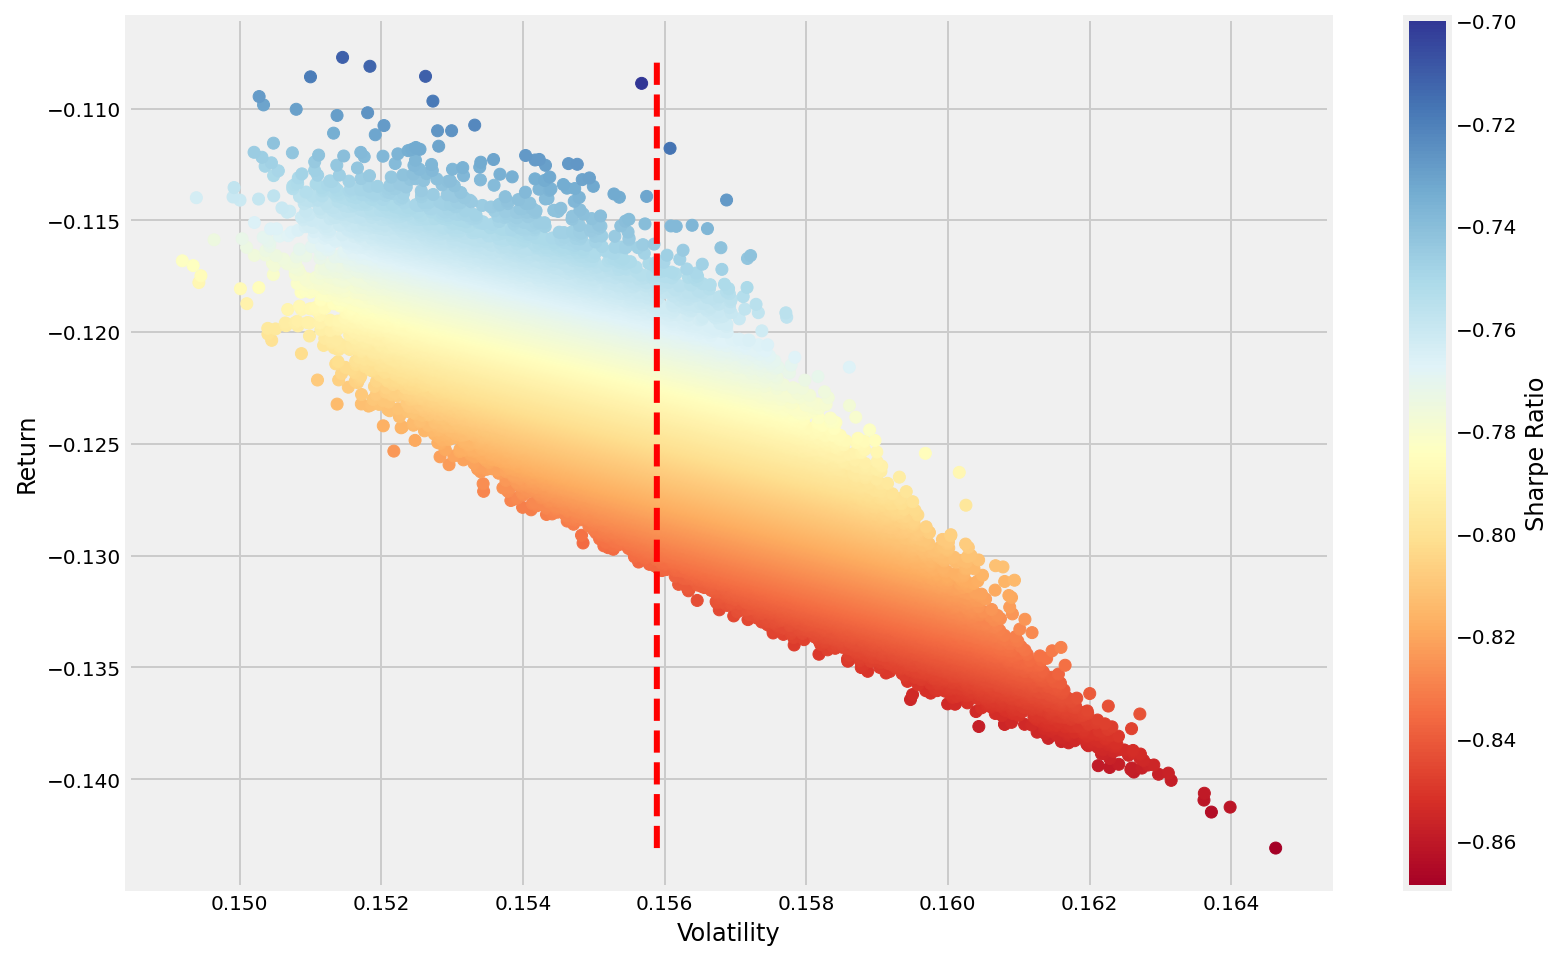

In [68]:
plt.figure(figsize=(12,8))
plt.scatter(vol_arr, ret_arr, c=sharpe_arr, cmap='RdYlBu')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.plot(frontier_x, frontier_y, 'r--', linewidth=3)
# plt.savefig('cover.png')
plt.show()